# Random Forest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

# Scikit-kearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Nos modules
from modules.random_forest import OurRandomForestClassifier
import modules.scoring as sc
import modules.feature_selection as fs
import modules.params_tuning as pt

## 1. Importation des données

In [3]:
data = pd.read_csv("data.csv")

In [4]:
print(data.shape)
data.head()

(1000, 32)


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,spectral_contrast,spectral_flatness,tonnetz,estimated_tempo,genre/label
0,country.00094,0.366838,0.206715,1474.849928,1745.839794,3108.264538,0.062993,-104.34503,136.39078,-20.945368,...,2.197093,-7.109390,1.849674,1.675598,-1.492039,23.567712,0.001825,0.026578,112.347147,country
1,country.00025,0.347253,0.079920,1565.431223,2016.069774,3188.930717,0.057303,-200.55273,119.67490,-3.610737,...,-11.293138,-8.870809,-8.073557,-3.161044,0.330751,19.845071,0.008667,0.018447,143.554688,country
2,country.00076,0.297332,0.128385,1321.679067,1409.586676,2590.392670,0.066525,-183.93301,159.80644,-23.158834,...,-3.583324,-9.062474,-3.159365,-4.068544,-7.052489,23.526738,0.001220,-0.013900,143.554688,country
3,country.00030,0.221390,0.079631,1240.515214,1996.754074,2412.635411,0.042844,-277.08127,128.25803,42.433240,...,1.391878,3.080010,2.513260,-1.051766,-2.753359,22.093318,0.002381,-0.009946,161.499023,country
4,country.00089,0.322114,0.104638,1321.678546,1667.211777,2583.926042,0.052503,-205.12328,140.99438,-8.959963,...,3.140506,-4.527332,2.654261,-3.122376,-10.710899,24.189410,0.001850,0.002900,143.554688,country


In [5]:
# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

# On change les noms des genres par des entiers (de 0 a 9)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

In [6]:
# On standardise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## 2. Apprentissage du modèle de base

In [7]:
# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


Notre random forest a cinq paramètres :
   - `n_trees` -- le nombre d'arbres de la forêt
   - `n_samples` -- le nombre de données à placer dans le noeud de chaque arbre avant qu'il ne soit partitionné
   - `n_cuts` -- le nombre de coupes à tester pour trouver la meilleure
   - `max_depth` -- la profondeur maximale de chaque arbre
   - `max_features` -- le nombre de caractéristiques à choisir lors de l'entraînement du modèle

`OurRandomForestClassifier` et `OurDecisionTreeClassifier` ont en commun les trois derniers paramètres. Nous avons trouver la meilleure combinaison de ces paramètres dans le notebook `MT-Decision_Tree.ipynb`.

In [8]:
with open("models/best_dtc.pickle", "rb") as output:
    best_dtc = pickle.load(output)

print("The best hyperparameters for a decision tree are:\n", best_dtc.get_params())

The best hyperparameters for a decision tree are:
 {'n_cuts': 40, 'max_depth': 45, 'max_features': 30}


Nous avons donc initialisé à ces valeurs les paramètres de la classe `OurRandomForestClassifier`. On entraîne le modèle de base, dont les paramètres par défaut sont :

        n_trees = 100
        n_samples = 100
        n_cuts = 40
        max_depth = 30
        max_features = 30

In [9]:
# Initialisation de la random forest
base_model = OurRandomForestClassifier() 

# Entrainement du modèle de base
start = time.time()
base_model.fit(data_train, label_train)
end = time.time()
print("Execution time for building the forest: %f sec"%(float(end) - float(start)))

# Test de validation
base_model_predictions = base_model.predict(data_test)
base_model.score_ = sc.accuracy_score(base_model_predictions, label_test) * 100

Execution time for building the forest: 32.737719 sec


In [10]:
# Comparaison avec sklearn
sklearn_rf = RandomForestClassifier(n_estimators=100, max_depth=45, max_features=30)
sklearn_rf.fit(data_train, label_train)
sklearn_predictions = sklearn_rf.predict(data_test)

In [11]:
print("Our random forest score : {} %".format(base_model.score_))
print("Sklearn score : {} %".format(sc.accuracy_score(sklearn_predictions, label_test) * 100))

Our random forest score : 66.0 %
Sklearn score : 71.0 %


## 3. Wrapper-based Feature Selection
Un moyen d'améliorer notre modèle est de sélectionner les caractéristiques les plus discriminantes.

In [12]:
print("Shape of the dataset ", data_train.shape)
print("Size of the dataset before feature selection: %.2f MB"%(data_train.nbytes/1e6))
features_name = data.drop(['genre/label'], axis=1).columns

Shape of the dataset  (800, 30)
Size of the dataset before feature selection: 0.19 MB


In [13]:
start = time.time()
features, importances = fs.findFeatureImportance(estimator=base_model, X=data_train, y=label_train)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

Execution time to find the most important feature: 38.737534 sec


In [14]:
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

,feature,importance
26,spectral_contrast,0.13000
0,chroma_stft,0.03750
9,mfcc4,0.03375
6,mfcc1,0.02000
25,mfcc20,0.01500
18,mfcc13,0.01375
19,mfcc14,0.01375
8,mfcc3,0.01250
27,spectral_flatness,0.01125
14,mfcc9,0.01125


On sélectionne les caractéristiques dont l'importance est supérieure à 0.01

In [15]:
# On sélectionne les caractéristiques dont l'importance est supérieure à 0.01
indexes = feature_importances[feature_importances['importance'] > 0.01].index

# On transforme le dataset d'entrainement (fs = feature selection)
fs_data_train = fs.transform(data_train, indexes)
fs_data_test = fs.transform(data_test, indexes)

print("Shape of the dataset ", fs_data_train.shape)
print("Size of the dataset after feature selection: %.2f MB"%(fs_data_train.nbytes/1e6))

Shape of the dataset  (800, 11)
Size of the dataset after feature selection: 0.07 MB


On entraîne le modèle de base avec les caractéristiques sélectionnées.

In [16]:
# Entrainement du modèle de base avec feature selection
fs_base_model = OurRandomForestClassifier(max_features=len(indexes))

start = time.time()
fs_base_model.fit(fs_data_train, label_train)
end = time.time()
print("Execution time for building the forest: %f sec"%(float(end) - float(start)))

# Test de validation
fs_base_model_predictions = fs_base_model.predict(fs_data_test)
fs_base_model.score_ = sc.accuracy_score(fs_base_model_predictions, label_test) * 100

Execution time for building the forest: 43.311919 sec


In [17]:
# Comparaison avec sklearn
sklearn_rf.max_features = len(indexes)
sklearn_rf.fit(fs_data_train, label_train)
fs_sklearn_predictions = sklearn_rf.predict(fs_data_test)

On compare les scores obtenus avant et après la sélection des caractéristiques.

In [27]:
# Score
print("Before feature selection")
print("Our random forest score: {} %".format(base_model.score_))
print("Sklearn score: {} %\n".format(sc.accuracy_score(sklearn_predictions, label_test)*100))

print("After feature selection")
print("Our random forest score: {} %".format(fs_base_model.score_))
print("Sklearn score: {} %".format(sc.accuracy_score(fs_sklearn_predictions, label_test)*100))

Before feature selection
Our random forest score: 66.0 %
Sklearn score: 71.0 %

After feature selection
Our random forest score: 64.0 %
Sklearn score: 66.5 %


## 4. Réglage des hyperparamètres

Il reste deux paramètres à optimiser. Il s'agit de :
   - `n_trees` -- le nombre d'arbres de la forêt
   - `n_samples` -- le nombre de données à placer dans le noeud de chaque arbre avant qu'il ne soit partitionné

### Grid Search Cross Validation
Nous avons décidé de sauter l'étape de la recherche randomisée et de passer directement à la recherche par quadrillage pour deux raisons :
- le nombre de combinaisons à tester est plutôt faible avec les intervalles que nous avons défini
- le temps d'exécution est incroyablement long

Donc nous avons préféré lancé une seule fois l'exécution, qui teste tous les combinaisons de paramètres possibles.

Justification des intervalles :
- `n_trees` : en testant rapidement avec la random forest de sklearn, nous avons observé que le score ne change pas de manière significative à partir de 600 arbres.
- `n_samples` : puisque nous effectuons une k-fold cv pour chaque modèle construit à partir d'une combinaison de paramètres, nous avons choisi arbitrairement de fixer `n_samples` à la taille du sous-échantillon créé lorsqu'on divise l'ensemble d'apprentissage en k sous-échantillons. 

In [19]:
k = 3 # k-fold CV

In [22]:
# n_trees
n_trees = [int(x) for x in np.linspace(start = 200, stop = 600, num = 5)] 

# n_samples
max_samples = data_train.shape[0]//k
n_samples = [int(x) for x in np.linspace(start = 100, stop = max_samples, num = 4)] 

# Creation de la grille
param_grid = {'n_trees': n_trees,
                'n_samples': n_samples}

from pprint import pprint
print("Grille d'hyperparametres :\n")
pprint(param_grid)

Grille d'hyperparametres :

{'n_samples': [100, 155, 210, 266], 'n_trees': [200, 300, 400, 500, 600]}


In [23]:
# 4 HEURES
# Instanciation du grid search model
grid_search_rfc = pt.GridSearchCV(estimator = OurRandomForestClassifier, 
                                  param_distributions = param_grid,
                                  cv = k)

# Entrainement du modele
start = time.time()
grid_search_rfc.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

Execution time for random search training: 14426.738479 sec


La meilleur combinaison d'hyperparamètres est :

In [24]:
print("The best hyperparameters from Grid Search are:\n", grid_search_rfc.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(grid_search_rfc.best_score_))

The best hyperparameters from Grid Search are:
 {'n_trees': 600, 'n_samples': 266, 'n_cuts': 40, 'max_depth': 45, 'max_features': 30}

The mean accuracy of a model with these hyperparameters is:
 0.72


On sauvegarde le meilleur modèle dans `best_rfc` :

In [25]:
best_rfc = grid_search_rfc.best_estimator_

## 5. Apprentissage du meilleur modèle et performance

Maintenant que nous avons le meilleur modèle, entraînons-le et observons ses performances.

In [26]:
# Entrainement du meilleur modele
start = time.time()
best_rfc.fit(data_train, label_train)
end = time.time()
print("Execution time for best random forest training: %f sec"%(float(end) - float(start)))

# Test de validation
best_rfc_predictions = best_rfc.predict(data_test)
best_rfc.score_ = sc.accuracy_score(best_rfc_predictions, label_test) * 100

Execution time for best random forest training: 512.638597 sec


### Matrice de confusion

In [29]:
# Association du genre a son label
d = {
    'genre': genre_list,
    'genre_code': labels
}
df_genre = pd.DataFrame(d).drop_duplicates().sort_values('genre_code')

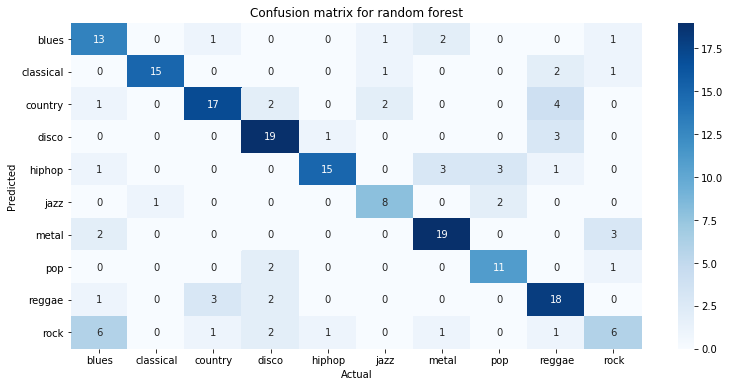

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(label_test, best_rfc_predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix for random forest')
plt.savefig("models/confusion_matrix_rfc.png")
plt.show()
plt.close()

Voyons si le réglage des hyperparamètres a permis d'obtenir un meilleur modèle.

In [31]:
print("Base model score: {} %".format(base_model.score_))
print("Best model score: {} %".format(best_rfc.score_ ))

Base model score: 66.0 %
Best model score: 70.5 %


Sauvegardons le score du modèle pour pouvoir le comparer aux autres modèles.

In [34]:
d = {
    'Model': 'Random Forest',
    'Test Set Accuracy': best_rfc.score_
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [35]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)

with open('Models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)